In [ ]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import nlopt
from matplotlib import pyplot as plt
import math
mp.verbosity(0)

# material 설정
Sio2=mp.Medium(index=2.0)
Air=mp.Medium(index=1.0)

wvl_r=0.64  #Blue
wvl_b=0.46 #Red
wvl_g=0.532 #green

wavelengths=np.array([wvl_r,wvl_g,wvl_b])
frequencies=1/wavelengths
width=0.2
frequencies_width=0.1

design_region_width=2
design_region_height=0.5
dpml=2 
dair=3
dsub=5

resolution=50

sx=design_region_width
sy=design_region_height+dpml*2+dsub+dair
cell_size=mp.Vector3(sx,sy)

# PML
pml_layers=[mp.PML(dpml)]

cell_size=mp.Vector3(sx,sy)

# PML
pml_layers=[mp.PML(thickness=dpml,direction=mp.Y)]

# conic filter radius
eta_i=0.5
eta_e=0.55
eta_d=1-eta_e
minimum_length=0.09

filter_radius=mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)

Nx=int(100)
Ny=int(1)
design_region_resolution=Nx/design_region_width

design_variables=mp.MaterialGrid(mp.Vector3(Nx,Ny),Air,Sio2,grid_type="U_MEAN")

design_region=mpa.DesignRegion(design_variables,
                               center=mp.Vector3(0,-0.5*sy+dpml+dair+0.5*design_region_height,0),
                               size=mp.Vector3(design_region_width,design_region_height))
geometry=[mp.Block(center=design_region.center,
                   size=design_region.size,
                   material=design_variables),

                   mp.Block(center=mp.Vector3(0,-0.5*sy+dpml+dair+design_region_height+0.5*(dsub+dpml),0),
                            size=mp.Vector3(design_region_width,dsub+dpml,0),
                            material=Sio2),
         ]
#
#size=mp.Vector3(design_region_width,dsub+dpml,0)
theta_inc_degree=-39.8
theta_r0=math.radians(-90-(theta_inc_degree)-90)
theta_r1=math.radians(0)

k0=mp.Vector3(0,(frequencies[0]*2.0),0).rotate(mp.Vector3(0,0,1),theta_r0)
k1=mp.Vector3((frequencies[0]),0,0).rotate(mp.Vector3(0,0,1),theta_r1)

source0=[
    mp.EigenModeSource(
        mp.GaussianSource(
            frequency=frequencies[0],
            fwidth=frequencies_width,is_integrated=True),
            eig_band=1,
            direction=mp.NO_DIRECTION,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
            center=mp.Vector3(0,0.5*sy-dpml,0),size=mp.Vector3(design_region_width,0,0),eig_kpoint=k0),
]

source1=[
    mp.
    
    Source(
        mp.GaussianSource(
            frequency=frequencies[0],
            fwidth=frequencies_width,is_integrated=True),
            eig_band=1,
            direction=mp.NO_DIRECTION,
            component=mp.Ez,
           center=mp.Vector3(0,0.5*sy-dpml,0),size=mp.Vector3(design_region_width,0,0),eig_kpoint=k1),
]

sim0=mp.Simulation(cell_size=cell_size
                   ,resolution=resolution,
                   boundary_layers=pml_layers,
                   sources=source0,
                   geometry=geometry,
                   k_point=k0)


dft_fields_r0=sim0.add_dft_fields([mp.Ez],frequencies[0],0,1,
                                center=mp.Vector3(0,-0.5*sy+dpml+dair+dsub*0.5,0),
                                size=mp.Vector3(design_region_width,0,0),yee_grid=True)
dft_fields_r1=sim0.add_dft_fields([mp.Ez],frequencies[0],0,1,
                                center=mp.Vector3(0,0,0),
                                size=mp.Vector3(design_region_width,dsub+dair+design_region_height,0),yee_grid=True)

sim1=mp.Simulation(cell_size=cell_size,resolution=resolution,boundary_layers=pml_layers,sources=source1,geometry=geometry,k_point=k1)

sim0.run(until_after_sources=50)

dft_fields_Ez=sim0.get_dft_array(dft_fields_r0,mp.Ez,0)



/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/source.py:594: RuntimeWarning: EigenModeSource component is not ALL_COMPONENTS (the default), which makes it non-unidirectional.
  warnings.warn(


In [7]:
import meep as mp
k0=mp.Vector3(0,(frequencies[0]*2.0),0).rotate(mp.Vector3(0,0,1),theta_r0)
k0

Vector3<2.0003428108904866, -2.4008860112297596, 0.0>

<Axes: xlabel='X', ylabel='Y'>

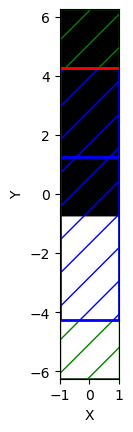

In [15]:
sim0.plot2D()

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


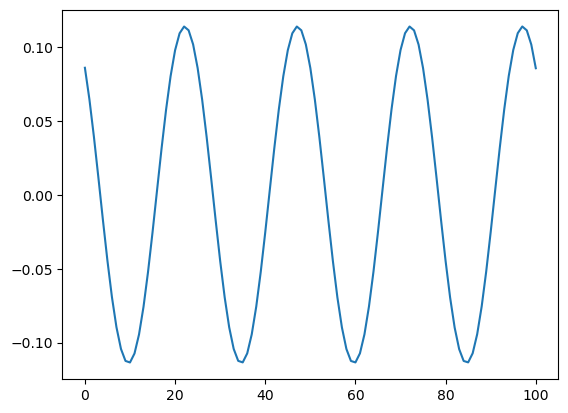

In [3]:
plt.plot(dft_fields_Ez)

In [ ]:
mode_0_ez=mpa.FourierFields(sim0,volume=mp.Volume(center=mp.Vector3(0,-0.5*sy+dpml+0.5*dair,0),
                                                size=mp.Vector3(design_region_width,0,0)),
                                                component=mp.Ez,yee_grid=True)

ob_list0=[mode_0_ez]

def M0(m0ez, fft_fields):
    length=len(fft_fields)
    m0ez_fft=npa.fft.fftshift(npa.fft.fft(m0ez[0,:]))/length
    
    kx = npa.fft.fftshift(npa.fft.fftfreq(len(m0ez_fft), 1 / resolution))
    num_index=npa.argmin(np.abs(kx))

    power0=npa.abs(m0ez_fft[num_index])**2

    return power0


opt0=mpa.OptimizationProblem(simulation=sim0,
                            objective_functions=[M0],
                            objective_arguments=ob_list0,
                            fcen=frequencies[0],
                            df=0,
                            nf=1,
                            design_regions=[design_region],
                            decay_by=1e-1,
                            )


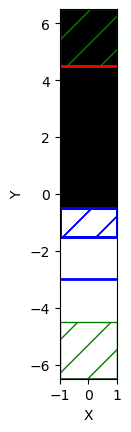

In [12]:
opt0.plot2D(True)

In [3]:
# Gradient calculation

evaluation_history_r=[]
evaluation_history_g=[]
evaluation_history_b=[]
cur_iter=[0]

evaluation_history_r = []
evaluation_history_g = []
evaluation_history_b = []

grad_mean_history = []
grad_max_history = []
binarization_history = []
beta_history = []
cur_iter = [0]
numevl = 1


 # 함수 설정
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon  # epsilon은
        self.mt = None           # m은 모멘텀 
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
        
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t


evaluation_history_r = []
evaluation_history_g = []
evaluation_history_b = []

binarization_history = []

beta_history = []

cur_iter = [0]

numevl = 1

lr_history=[]

uf_history=[]
t_history=[]
adjgrad_history=[]
lr_history = []

optimizer = AdamOptimizer(lr=0.02, beta1=0.9)

def f(v,eta, cur_beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))
    
    binarization_degree = np.sum(np.abs(v-0.5))*2 / (v.size)
    binarization_history.append(binarization_degree)
    
    
    
    #f0_r, dJ_du0 = opt0([mapping(v, eta, cur_beta)])
    
    f0_r, dJ_du0 = opt0([v])
    #f1_r, dJ_du1 = opt1([mapping(v, eta, cur_beta)])

   
    f0=np.array([np.real(f0_r)])
    #f1=np.array([np.real(f1_r)])

    # Adjoint gradient
    if v.size > 0:
        gradient0 = v*0
        #gradient1=v*0

        gradient0[:] = dJ_du0
     #   gradient1[:] = tensor_jacobian_product(mapping, 0)(v, eta, cur_beta, dJ_du1)


        
        gradient=gradient0#gradient1
        
        adjgrad_norm = gradient.mean()
        adjgrad_history.append(adjgrad_norm) 

        # Optimize design
        updated_x, adam_lr, adam_uf, adam_m, adam_v, adam_t = optimizer.update(v, gradient)
        
        cur_beta= cur_beta+ npa.tanh((cur_beta-0.5)*0.01)
        evaluation_history_r.append(f0_r)
        beta_history.append(cur_beta)
        cur_iter[0] = cur_iter[0] + 1
        lr_history.append(adam_lr)
        uf_history.append(adam_uf)
        t_history.append(adam_t)
        
        print("Current FoM0: {}".format(np.real(f0)))
      #  print("Current FoM1: {}".format(np.real(f1)))

        print("Current_beta:{}".format(cur_beta))

        
        return updated_x, adam_m, adam_v, cur_beta


# start optimization
# 
total_iter = 200
cur_beta=1
n=Nx*Ny
x=np.ones(n)*0.5


In [4]:
for iters in range(total_iter):
    x, adam_m, adam_v, cur_beta = f(x,eta_i,cur_beta)
    


Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [0.00021226]
Current_beta:1.0049999583337499
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [6.57447785]
Current_beta:1.0100499149883275
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [19.72574187]
Current_beta:1.0151503699086868
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [39.43511985]
Current_beta:1.0203018280380722
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [65.61432456]
Current_beta:1.0255047993679662
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current FoM0: [98.03125074]
Current_beta:1.030759798988536
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating grad

FloatProgress(value=0.0, description='0% done ', max=300.0)

(-1.01, 1.01, -4.259976525821596, 4.259976525821596)

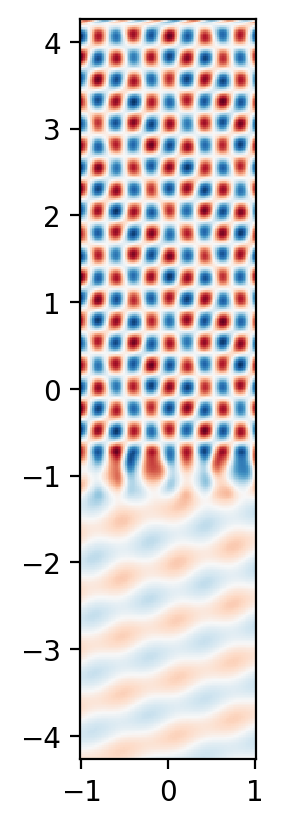

In [ ]:
sim0.reset_meep()

theta_inc_degree=-51.2
theta_r0=math.radians(-90-(theta_inc_degree)-90)
theta_r1=math.radians(0)

k0=mp.Vector3(0,(frequencies[0]*2.0),0).rotate(mp.Vector3(0,0,1),theta_r0)
k1=mp.Vector3((frequencies[0]),0,0).rotate(mp.Vector3(0,0,1),theta_r1)

geometry=[mp.Block(center=design_region.center,size=design_region.size,material=design_variables),mp.Block(center=mp.Vector3(0,-0.5*sy+dpml+dair+design_region_height+0.5*(dsub+dpml),0),size=mp.Vector3(design_region_width,dsub+dpml,0),material=Sio2),
         ]

source0=[
    mp.EigenModeSource(
        mp.GaussianSource(
            frequency=frequencies[0],
            fwidth=frequencies_width,is_integrated=True),
            eig_band=1,
            direction=mp.NO_DIRECTION,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
            center=mp.Vector3(0,0.5*sy-dpml,0),size=mp.Vector3(design_region_width,0,0),eig_kpoint=k0),
]

sim0=mp.Simulation(cell_size=cell_size,resolution=resolution,boundary_layers=pml_layers,sources=source0,geometry=geometry,k_point=k0)


dft_fields_r0=sim0.add_dft_fields([mp.Ez],frequencies[0],0,1,
                                center=mp.Vector3(0,-0.5*sy+dpml+0.5*dair,0),
                                size=mp.Vector3(design_region_width,0,0),yee_grid=True)
dft_fields_r1=sim0.add_dft_fields([mp.Ez],frequencies[0],0,1,
                                center=mp.Vector3(0,0,0),
                                size=mp.Vector3(design_region_width,dsub+dair+design_region_height,0),yee_grid=True)

sim0.run(until_after_sources=200)
Ez_r0=sim0.get_dft_array(dft_fields_r0,mp.Ez,0)
Ez_r1=sim0.get_dft_array(dft_fields_r1,mp.Ez,0)

xdim=np.linspace(-0.5*sx,0.5*sx,sx*resolution+1)
ydim=np.linspace(-0.5*sy+dpml,0.5*sy-dpml,len(Ez_r1[1,:]))
plt.figure(dpi=200)
plt.pcolor(xdim,ydim,np.transpose(np.real(Ez_r1)),cmap="RdBu")
plt.axis("scaled")

In [57]:
np.arcsin((4*0.64/2-np.sin(-16.26*np.pi/180))/2)*180/np.pi

51.26041838218616

(-3.0, 3.0)

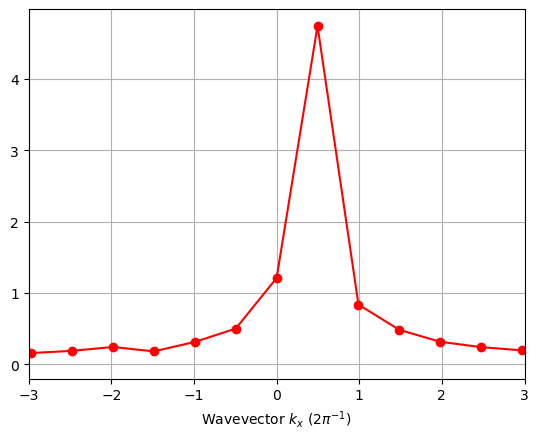

In [32]:
x = np.linspace(-0.5 * sx, 0.5 * sx, design_region_width*resolution+1)
theta_inc = np.radians(-20)
lambda0 = 0.64
k0 = 2*np.pi/ lambda0
kx0 =  -2*k0 * np.sin(theta_inc) 
Ez_comp=Ez_r0[:]
m0ez_fft=npa.fft.fftshift(npa.fft.fft(Ez_comp))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), 1 / resolution))

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.grid()
plt.xlim([-3,3])


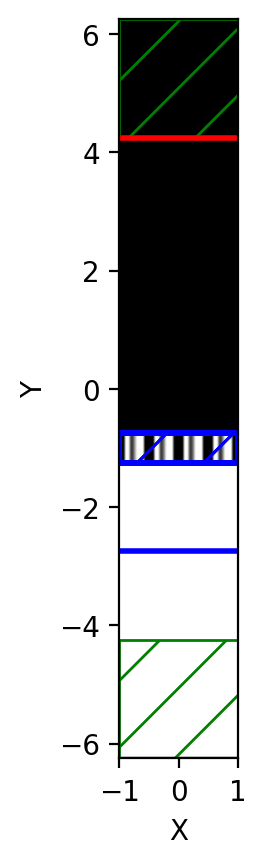

In [22]:
plt.figure(dpi=200)
opt0.plot2D(True)

In [ ]:
r

FloatProgress(value=95.0, description='0% done ', max=125.0, min=95.0)

<Axes: xlabel='X', ylabel='Y'>

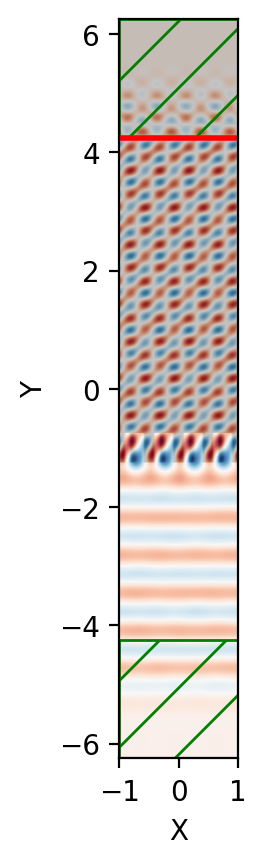

In [15]:

plt.figure(dpi=200)
sim0.run(until=30)
sim0.plot2D(fields=mp.Ez)

FloatProgress(value=0.0, description='0% done ', max=200.0)

TypeError: 'float' object cannot be interpreted as an integer

In [13]:
np.shape(Ez_r1)

(101,)

ValueError: not enough values to unpack (expected 2, got 1)

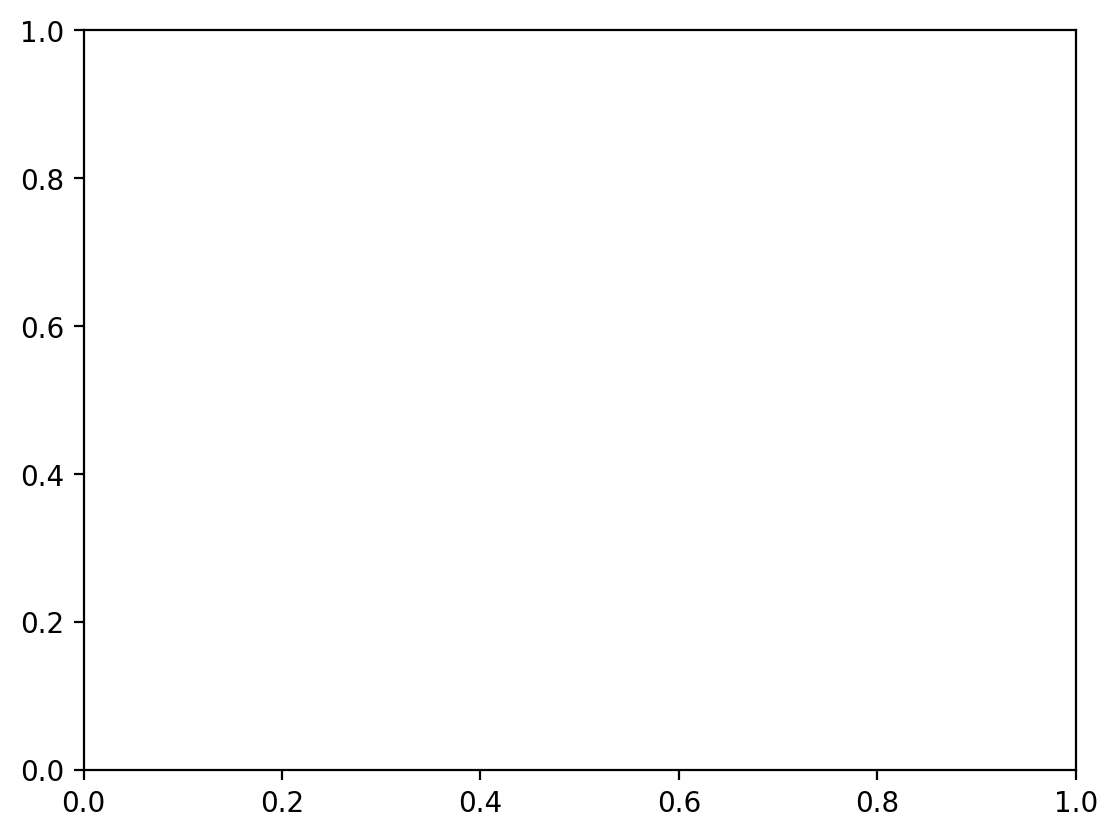

In [12]:
plt.figure(dpi=200)
plt.pcolor(np.transpose(np.real(Ez_r1)),cmap="RdBu")
plt.axis("scaled")


In [9]:
np.shape(Ez_r0)

(101,)

<Axes: xlabel='X', ylabel='Y'>

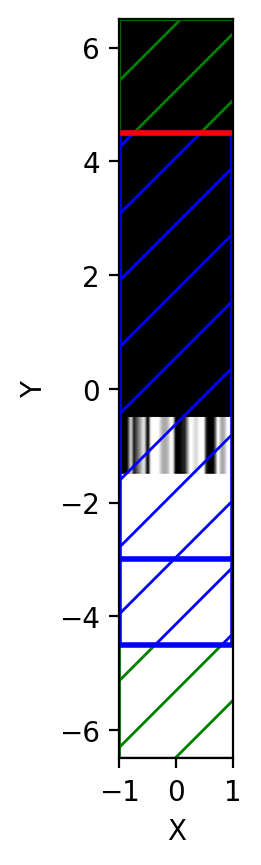

In [8]:
plt.figure(dpi=200)
sim0.plot2D()

In [3]:
sim0.run(until_after_sources=100)
Ez_r0=sim0.get_dft_array(dft_fields_r0,mp.Ez,0)
Ez_r1=sim0.get_dft_array(dft_fields_r1,mp.Ez,0)

FloatProgress(value=0.0, description='0% done ', max=200.0)

(-1.01, 1.01, -4.51, 4.51)

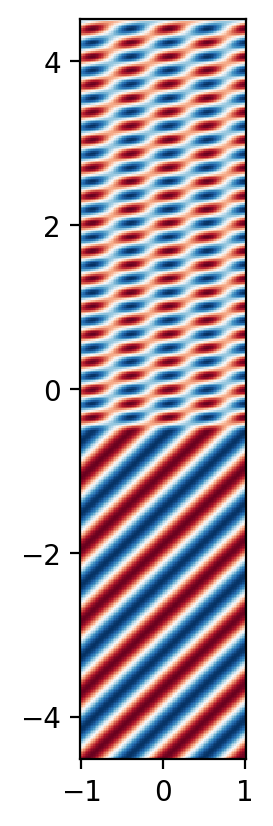

In [3]:
xdim=np.linspace(-0.5*sx,0.5*sx,sx*resolution+1)
ydim=np.linspace(-0.5*sy+dpml,0.5*sy-dpml,(sy-2*dpml)*resolution+1)
plt.figure(dpi=200)
plt.pcolor(xdim,ydim,np.transpose(np.real(Ez_r1)),cmap="RdBu")
plt.axis("scaled")

/home/lee/miniconda3/envs/mp/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


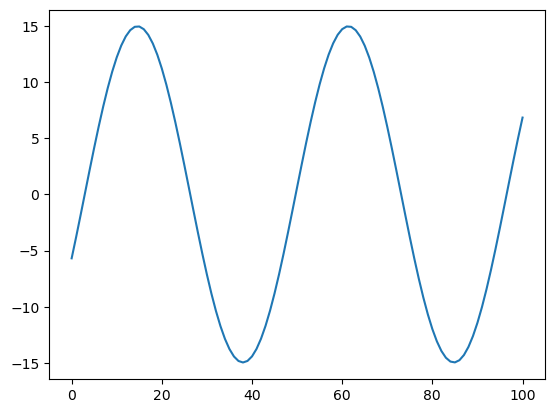

In [79]:
plt.plot(Ez_r0)

In [57]:
x = np.linspace(-0.5 * sx, 0.5 * sx, design_region_width*resolution+1)
theta_inc = np.radians(-20)
lambda0 = 0.64
k0 = 2*np.pi/ lambda0
kx0 =  -2*k0 * np.sin(theta_inc) 
Ez_comp=Ez_r0[:]
m0ez_fft=npa.fft.fftshift(npa.fft.fft(Ez_comp))/(design_region_width*resolution+1)
kx = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), 1 / resolution))


Text(0.5, 0, 'sin(theta) (air)')

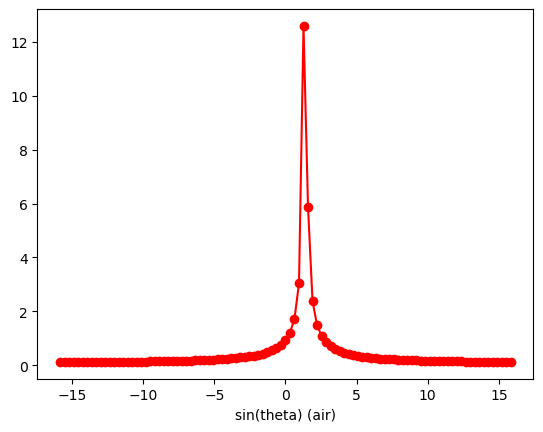

In [42]:
theta_out = np.arcsin(2 * np.sin(theta_inc))  # Snell's Law
kx_air = (2 * np.pi / lambda0) * np.sin(theta_out)
Ez_comp = Ez_r0[:] * np.exp(-1j * kx_air * x)
Ez_fft = npa.fft.fftshift(npa.fft.fft(Ez_comp)) / len(Ez_comp)
kx_axis = npa.fft.fftshift(np.fft.fftfreq(len(Ez_comp), d=1/resolution))
kx_rad = 2 * np.pi * kx_axis  # [rad/μm]
sin_theta = kx_rad * lambda0 / (2 * np.pi)  # = sin(θ)
plt.plot(sin_theta, np.abs(Ez_fft), 'r-o')
plt.xlabel("sin(theta) (air)")


In [60]:
kx0

-3.357774905161403

(-2.0, 2.0)

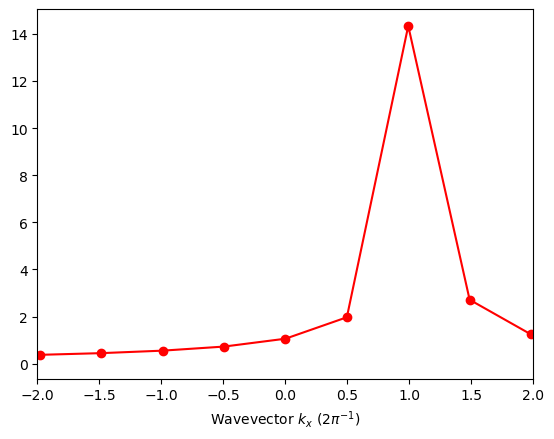

In [58]:

plt.plot(kx,np.abs(m0ez_fft),"-ro")
plt.xlabel(r"Wavevector $k_x$ (2$\pi^{-1}$)")
plt.xlim([-2,2])


In [9]:
k0/np.pi/2

1.5625

In [66]:
np.mean(kx*(np.abs(Ez_fft)))

0.8182463944791925

In [23]:
(-2*np.sin(-20*np.pi/180)+0*0.64/2)/0.64

1.0688129478927146

In [7]:
np.arcsin(-2*np.sin(-20*np.pi/180)-0*0.64/2)*180/np.pi

43.160177799818335

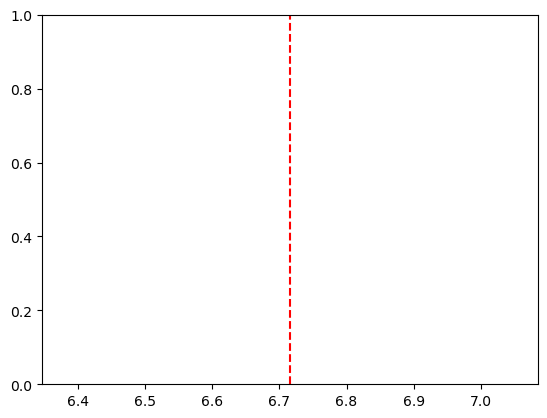

In [26]:
m = 0
theta = np.radians(20)
n_eff = 2.0
lambda0 = 0.64
k0 = 2 * np.pi / lambda0
kx_pred = m * 2 * np.pi / 2 + 2 * k0 * np.sin(theta)

plt.axvline(kx_pred, color='red', linestyle='--', label="Predicted kx")

In [70]:
idx_kx0 = np.argmin(np.abs(kx))
idx_kx0

50

In [ ]:
mode_0_ez=mpa.FourierFields(sim0,volume=mp.Volume(center=mp.Vector3(0,-0.5*sy+dpml+0.5*dair,0),
                                                size=mp.Vector3(design_region_width,0,0)),
                                                component=mp.Ez,yee_grid=True)

ob_list0=[mode_0_ez]
def M0(m0ez):
    
    m0ez_fft=npa.fft.fftshift(npa.fft.fft(m0ez[0,:]))
    length=len(m0ez_fft)
    power0=npa.abs(m0ez_fft[round(length/2)])

    return power0



opt0=mpa.OptimizationProblem(simulation=sim0,
                            objective_functions=[M0],
                            objective_arguments=ob_list0,
                            fcen=frequencies[0],
                            df=0,
                            nf=1,
                            design_regions=[design_region],
                            decay_by=1e-1,
                            )


mode_1_ez=mpa.FourierFields(sim1,volume=mp.Volume(center=mp.Vector3(-0.5*sx+dpml+dsub+design_region_height+0.5*dsub,0,0),
                                                size=mp.Vector3(0,design_region_width,0)),
                                                component=mp.Ez,yee_grid=True)


<Axes: xlabel='X', ylabel='Y'>

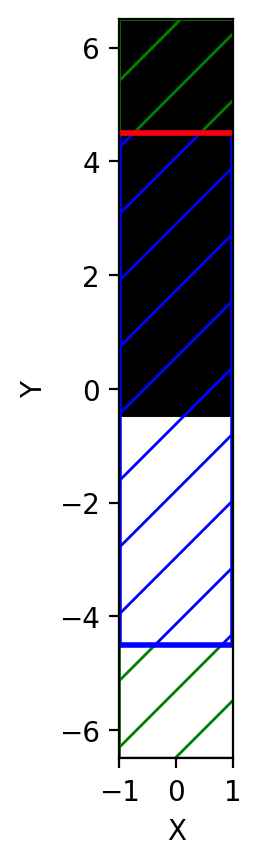

In [2]:
plt.figure(dpi=200)
sim0.plot2D()

In [5]:
a=np.arcsin(0.64/2*4/2)
a*180/np.pi

39.791819499557235

In [11]:
np.arcsin(2*np.sin(20/180*np.pi))*180/np.pi

43.160177799818335

In [ ]:
np.

In [ ]:
np.arcsin(2*np.sin(20/180*np.pi)-0.64/4)

FloatProgress(value=0.0, description='0% done ', max=130.0)

<Axes: xlabel='X', ylabel='Y'>

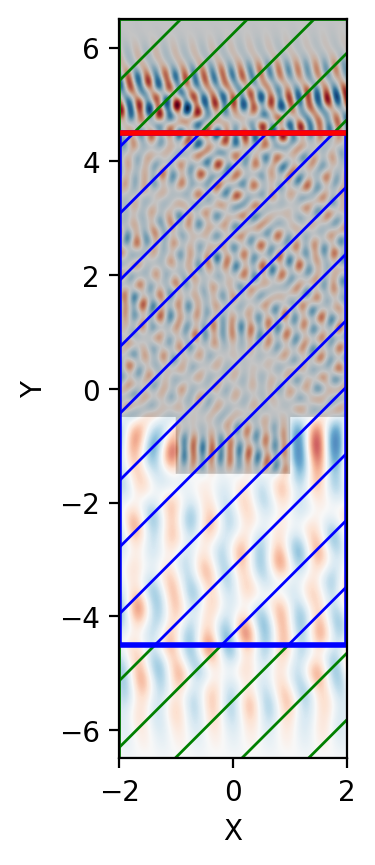

In [3]:
sim0.run(until_after_sources=30)
plt.figure(dpi=200)
sim0.plot2D(fields=mp.Ez)

<Axes: xlabel='X', ylabel='Y'>

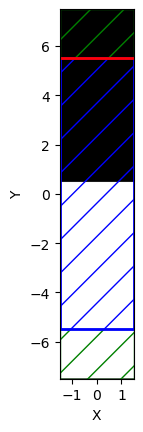

In [2]:
sim0.plot2D()

In [ ]:
xdim=np.linspace(-0.5*sx,0.5*sx,sx*resolution+1)
ydim=np.linpsace(-0.5*sy+dpml,0.5*sy-dpml,(sy-2*dpml)*resolution+1)

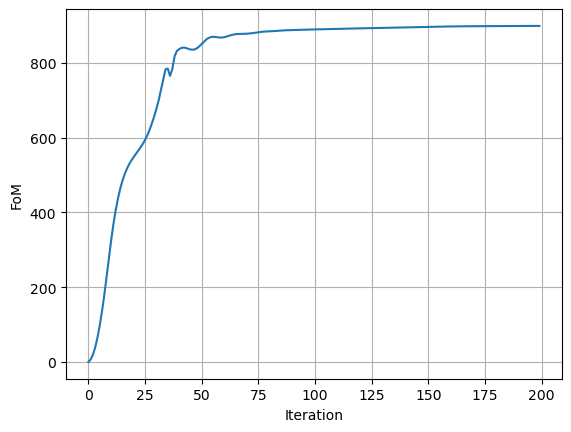

In [25]:
plt.plot(evaluation_history_r)
plt.xlabel("Iteration")
plt.ylabel("FoM")
plt.grid()

In [14]:
x=np.random.rand(n)
t=mapping(x,eta_i,cur_beta)

In [15]:
t

array([[0.68764252, 0.66026091, 0.63742287, ..., 0.53596755, 0.52679951,
        0.53007403],
       [0.63412058, 0.61612884, 0.60475214, ..., 0.5153329 , 0.50937635,
        0.51051758],
       [0.58765561, 0.58008307, 0.57610192, ..., 0.4939754 , 0.4846497 ,
        0.48249255],
       ...,
       [0.36982781, 0.40828631, 0.43679284, ..., 0.55892312, 0.56832039,
        0.56998138],
       [0.35084049, 0.39420241, 0.42737681, ..., 0.56924183, 0.59100652,
        0.60767161],
       [0.34191551, 0.38659865, 0.42446345, ..., 0.58475741, 0.61755281,
        0.64794462]])

FloatProgress(value=0.0, description='0% done ', max=200.0)

(-1.01, 1.01, -4.51, 4.51)

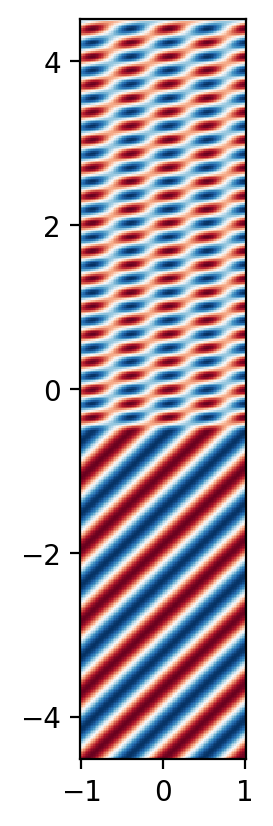

In [2]:
sim0.run(until_after_sources=100)
Ez_r0=sim0.get_dft_array(dft_fields_r0,mp.Ez,0)
xdim=np.linspace(-0.5*sx,0.5*sx,sx*resolution+1)
ydim=np.linspace(-0.5*sy+dpml,0.5*sy-dpml,(sy-2*dpml)*resolution+1)
plt.figure(dpi=200)
plt.pcolor(xdim,ydim,np.transpose(np.real(Ez_r0)),cmap="RdBu")
plt.axis("scaled")

In [6]:
Ez_r0

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -7.79063637e-07-7.68921434e-07j, -7.67686594e-07-2.04280446e-07j,
        -9.66101086e-07-1.44591365e-07j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -1.12179702e-06-1.07807745e-06j, -1.17639712e-06-3.22994554e-07j,
        -1.55075389e-06-6.81795993e-08j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
        -1.26159650e-06-1.15671487e-06j, -1.53291148e-06-6.08337412e-07j,
        -1.93119189e-06+4.61856278e-08j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         4.44467779e-07-4.12080092e-08j,  1.49543110e-07-2.09857498e-07j,
        -3.20783229e-07-2.33677609e-08j],
       [ 0.00000000e+00+0.00000000e+00j,  0.

In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import nlopt
from matplotlib import pyplot as plt
import math
mp.verbosity(0)

# material 설정
Sio2=mp.Medium(index=np.sqrt(3.9))
Air=mp.Medium(index=1.0)

wvl_r=0.64  #Blue
wvl_b=0.46 #Red
wvl_g=0.532 #green

wavelengths=np.array([wvl_r,wvl_g,wvl_b])
frequencies=1/wavelengths
width=0.2
frequencies_width=0.1

design_region_width=4
design_region_height=1
dpml=2 
dair=5
dsub=4

resolution=50

sy=design_region_width
sx=dpml*2+dsub
cell_size=mp.Vector3(sx,sy)

# PML
pml_layers=[mp.PML(thickness=dpml,direction=mp.X)]

# conic filter radius
eta_i=0.5
eta_e=0.55
eta_d=1-eta_e
minimum_length=0.09

filter_radius=mpa.get_conic_radius_from_eta_e(minimum_length,eta_e)

design_region_resolution=int(30)

Nx=int(design_region_height*design_region_resolution+1)
Ny=int(design_region_width*design_region_resolution+1)

design_variables=mp.MaterialGrid(mp.Vector3(Nx,Ny),Air,Sio2,grid_type="U_MEAN")
design_region=mpa.DesignRegion(design_variables,center=mp.Vector3(0,-0.5*sy+dpml+dair+0.5*design_region_height,0),size=mp.Vector3(design_region_width,design_region_height))
geometry=[mp.Block(center=mp.Vector3(-0.5*sx+dpml+0.5*dsub,0,0),size=mp.Vector3(dsub+2*dpml,design_region_width,0),material=Sio2)]
theta_r0=np.radians(10)
theta_r1=math.radians(0)

k0=mp.Vector3((frequencies[0]*np.sqrt(3.9)),0,0).rotate(mp.Vector3(0,0,1),theta_r0)
k1=mp.Vector3((frequencies[0]),0,0).rotate(mp.Vector3(0,0,1),theta_r1)

source0=[
    mp.EigenModeSource(
        mp.ContinuousSource(
            frequency=frequencies[0],
            fwidth=frequencies_width),
            eig_band=1,
            direction=mp.NO_DIRECTION,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
           component=mp.Ez,
            center=mp.Vector3(-0.5*sx+dpml,0,0),size=mp.Vector3(0,design_region_width,0),eig_kpoint=k0),
]

source1=[
    mp.EigenModeSource(
        mp.GaussianSource(
            frequency=frequencies[0],
            fwidth=frequencies_width,is_integrated=True),
            eig_band=1,
            direction=mp.X,
            component=mp.Ez,
           center=mp.Vector3(0,0.5*sy-dpml,0),size=mp.Vector3(design_region_width,0,0),eig_kpoint=k1),
]

sim0=mp.Simulation(cell_size=cell_size,resolution=resolution,boundary_layers=pml_layers,sources=source0,geometry=geometry,k_point=k0)


dft_fields_r0=sim0.add_dft_fields([mp.Ez],frequencies[0],0,1,
                                center=mp.Vector3(0,0,0),
                                size=mp.Vector3(sx-2*dpml,design_region_width,0),yee_grid=True)


sim1=mp.Simulation(cell_size=cell_size,resolution=resolution,boundary_layers=pml_layers,sources=source1,geometry=geometry,k_point=k1)

/home/lee/miniconda3/envs/mp/lib/python3.8/site-packages/meep/source.py:594: RuntimeWarning: EigenModeSource component is not ALL_COMPONENTS (the default), which makes it non-unidirectional.
  warnings.warn(


In [8]:
k0

Vector3<3.0388116905392333, 0.5358244903343692, 0.0>

<Axes: xlabel='X', ylabel='Y'>

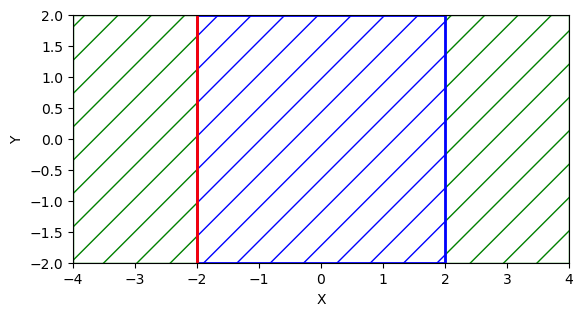

In [2]:
sim0.plot2D()

FloatProgress(value=50.0, description='0% done ', max=60.0, min=50.0)

<Axes: xlabel='X', ylabel='Y'>

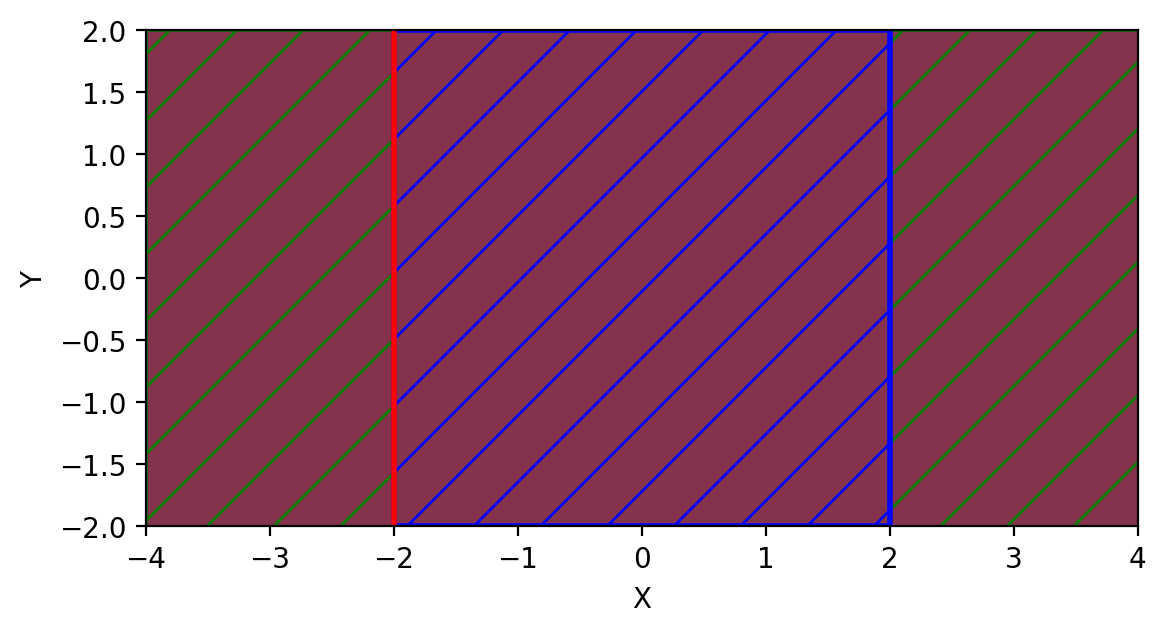

In [7]:
sim0.run(until=10)
plt.figure(dpi=200)
sim0.plot2D(fields=mp.Ey)

FloatProgress(value=42.0, description='0% done ', max=43.0, min=42.0)

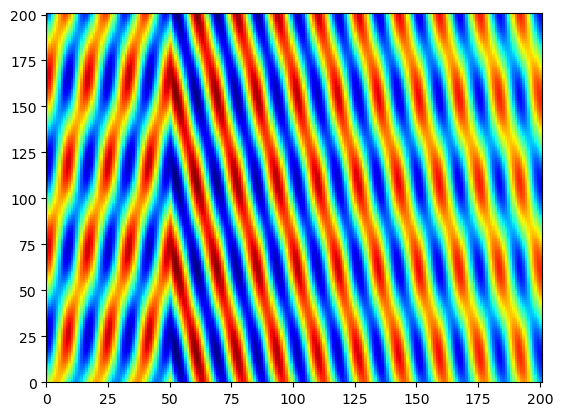

In [9]:
sim0.run(until=1)
Ez_r0=sim0.get_dft_array(dft_fields_r0,mp.Ez,0)
plt.pcolor(np.transpose(np.real(Ez_r0)),cmap="jet")

In [ ]:
sim0.run(until=1)

In [ ]:
sim0.run(until=1)

<Axes: xlabel='X', ylabel='Y'>

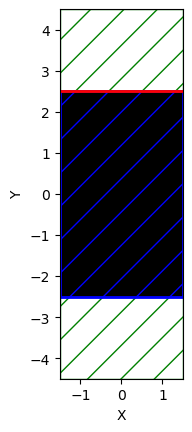

In [ ]:
sim0.plot2D()

In [66]:
np.arcsin(0.64/4/2*8)*180/np.pi

39.791819499557235

In [67]:
2*np.sin(np.radians(-39.8))

-1.2802193989699109

In [68]:
-4*0.64/2

-1.28

In [89]:
4*np.sin(np.radians(39.8))/0.426

6.01041971347376

In [102]:
np.arcsin(5*0.46/2/2)*180/np.pi

35.09963219539352